In [1]:
import numpy as np
import matplotlib.pyplot as plt
import celerite as celery
import exoplanet as xo
import pymc3 as pm
import theano
import theano.tensor as tt
from exoplanet.gp import terms, GP

In [2]:
theano.config.gcc.cxxflags = "-Wno-c++11-narrowing" # thx dfm

In [3]:
xo.__version__

'0.2.6'

In [4]:
np.random.seed(42)

#### generate RVs on a dense grid of times:

In [5]:
log_S0 = -1.0
log_Q = 7.0
log_omega0 = np.log(2.*np.pi / 300.) # 5-minute period

In [6]:
kernel_onemode = celery.terms.SHOTerm(log_S0, log_Q, log_omega0)

In [7]:
dt = 10. # grid spacing (s)
duration = 2. * 3600. # s
t_all = np.arange(0, duration, dt)

In [8]:
tlim_plot = [100, 7000]

In [9]:
gp_mean = 0.0 # actual center-of-mass rvs

In [10]:
gp = celery.GP(kernel_onemode, mean=gp_mean)
gp.compute(t_all)
y_all = gp.sample()

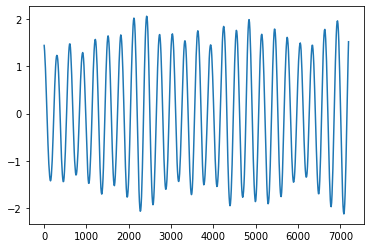

In [11]:
plt.plot(t_all, y_all);

#### bin down to simulate longer exposures:

In [12]:
from scipy.interpolate import interp1d

In [13]:
t = []
y = []

exp_time = 4. * 60.
n_exp = int(duration/exp_time) - 2

interp = interp1d(t_all, y_all, kind='cubic')
tiny = 0.1 # 100 ms
for n in range(n_exp):
    stt = 100. + n*exp_time # start time for this exposure, assumes no read time
    stt += np.abs(np.random.normal(0., 60.)) # small perturbation
    if stt+exp_time < t_all[-1]: # make sure we didn't perturb our way past the end of the data
        fine_ts = np.arange(stt, stt+exp_time, tiny) # fine grid
        fine_rvs = interp(fine_ts)
        avg_rv = np.sum(fine_rvs)/len(fine_rvs) # technically incorrect but close enough
        y.append(avg_rv)
        t.append(stt + exp_time/2.)

t = np.array(t)
y = np.array(y)

In [14]:
exp_time = 4. * 60.
n_exp = int(duration/exp_time) - 2

t_dense = []
y_dense = []

interp = interp1d(t_all, y_all, kind='cubic')
tiny = 0.1 # 100 ms
for stt in np.linspace(t_all[0], t_all[-1]-exp_time, 500):
    if stt+exp_time < t_all[-1]: # make sure we didn't perturb our way past the end of the data
        fine_ts = np.arange(stt, stt+exp_time, tiny) # fine grid
        fine_rvs = interp(fine_ts)
        avg_rv = np.sum(fine_rvs)/len(fine_rvs) # technically incorrect but close enough
        t_dense.append(stt + exp_time/2.)
        y_dense.append(avg_rv)

t_dense = np.array(t_dense)
y_dense = np.array(y_dense)

In [15]:
validation_inds = np.sort(np.random.choice(len(t), size=int(len(t)/2), 
                                           replace=False)) # 50% of epochs as validation
validation_mask = np.isin(np.arange(len(t)), validation_inds)
t_val = t[validation_mask]
y_val = y[validation_mask]
t_obs = t[~validation_mask]
y_obs = y[~validation_mask]

In [16]:
# add photon noise:
noise_amp = 0.1
yerr_obs = np.zeros_like(y_obs) + noise_amp
y_obs += np.random.normal(0., noise_amp, len(y_obs))

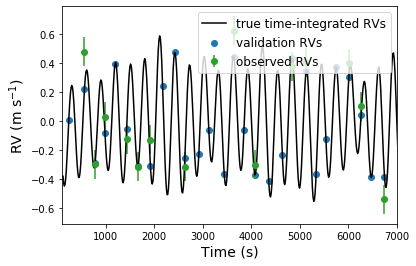

In [17]:
plt.plot(t_dense, y_dense, c='k', label='true time-integrated RVs')
plt.scatter(t, y, c='C0', label='validation RVs')
plt.errorbar(t_obs, y_obs, yerr_obs, c='C2', label='observed RVs', ls='', marker='o')
plt.legend(fontsize=12)
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel(r'RV (m s$^{-1}$)', fontsize=14)
plt.xlim(tlim_plot);

#### model with a non-integrated kernel:

This shouldn't work too well.

In [18]:
#t_plot = np.linspace(*tlim_plot, 200)
with pm.Model() as model:
    kernel = terms.SHOTerm(log_S0=log_S0, log_w0=log_omega0, log_Q=log_Q)
    gp = GP(kernel, t_obs, yerr_obs ** 2)
    gp.condition(y_obs)
    mu, var = xo.eval_in_model(gp.predict(t_dense, return_var=True))
    sd = np.sqrt(var)
    y_pred = xo.eval_in_model(gp.predict())
    y_val_pred = xo.eval_in_model(gp.predict(t_val))

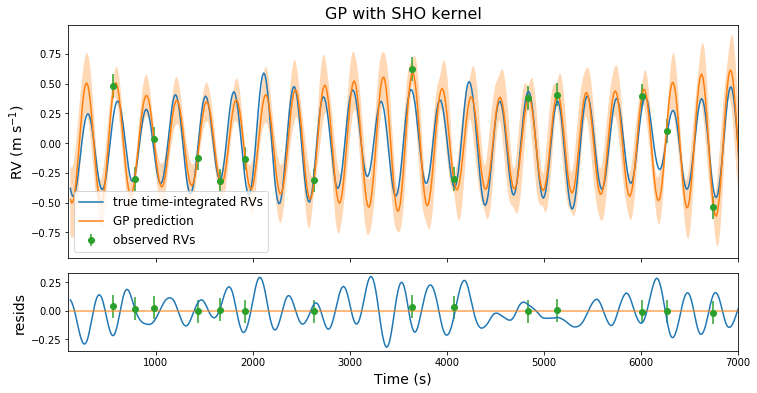

In [19]:
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(12,6), sharex=True, 
                              gridspec_kw={'height_ratios':[3,1], 'hspace':0.1})

#ax1.plot(t_all, y_all, c='k', label='true RVs')
ax1.plot(t_dense, y_dense, c='C0', label='true time-integrated RVs')
ax1.errorbar(t_obs, y_obs, yerr_obs, c='C2', label='observed RVs', ls='', marker='o')
#ax1.scatter(t_val, y_val, c='C0', label='validation RVs')

art = ax1.fill_between(t_dense, mu + sd, mu - sd, color="C1", alpha=0.3)
art.set_edgecolor("none")
ax1.plot(t_dense, mu, color="C1", label='GP prediction')
ax1.legend(fontsize=12)
ax2.errorbar(t_obs, y_obs - y_pred, yerr_obs, c='C2', ls='', marker='o')
#ax2.scatter(t_val, y_val - y_val_pred, c='C0')
ax2.plot(t_dense, y_dense - mu, color='C0')
ax2.plot(t_dense, np.zeros_like(mu), color="C1", alpha=0.7)
ax2.set_xlabel('Time (s)', fontsize=14)
ax1.set_ylabel(r'RV (m s$^{-1}$)', fontsize=14)
ax2.set_ylabel(r'resids', fontsize=14)
ax1.set_xlim(tlim_plot)
ax1.set_title('GP with SHO kernel', fontsize=16)
plt.savefig('gp_nonintegrated.png');

In [20]:
print(np.sum((y_dense - mu)**2/var))

224.61151066022654


#### model with an integrated kernel:

This *should* work well.

In [21]:
#t_plot = np.linspace(*tlim_plot, 500)
with pm.Model() as model:
    kernel = terms.SHOTerm(log_S0=log_S0, log_w0=log_omega0, log_Q=log_Q)
    kernel_int = terms.IntegratedTerm(kernel, exp_time)
    gp = GP(kernel_int, t_obs, yerr_obs ** 2)
    gp.condition(y_obs)
    mu, var = xo.eval_in_model(gp.predict(t_dense, return_var=True, kernel=kernel_int))
    mu_nonint = xo.eval_in_model(gp.predict(t_dense, kernel=kernel))
    sd = np.sqrt(var)
    y_pred = xo.eval_in_model(gp.predict()) # predictions for training data
    y_val_pred = xo.eval_in_model(gp.predict(t_val))# predictions for validation set

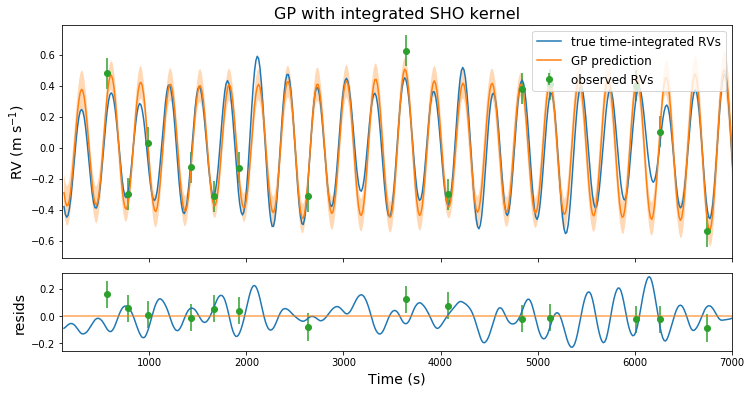

In [22]:
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(12,6), sharex=True, 
                              gridspec_kw={'height_ratios':[3,1], 'hspace':0.1})

ax1.plot(t_dense, y_dense, c='C0', label='true time-integrated RVs')
ax1.errorbar(t_obs, y_obs, yerr_obs, c='C2', label='observed RVs', ls='', marker='o')
#ax1.scatter(t_val, y_val, c='C0', label='validation RVs')

art = ax1.fill_between(t_dense, mu + sd, mu - sd, color="C1", alpha=0.3)
art.set_edgecolor("none")
ax1.plot(t_dense, mu, color="C1", label='GP prediction')
#ax1.plot(t_dense, mu_nonint, color="C3", label='non-integrated GP')
ax1.legend(fontsize=12)
ax2.errorbar(t_obs, y_obs - y_pred, yerr_obs, c='C2', ls='', marker='o')
#ax2.scatter(t_val, y_val - y_val_pred, c='C0')
ax2.plot(t_dense, y_dense - mu, color='C0')
ax2.plot(t_dense, np.zeros_like(mu), color="C1", alpha=0.7)

ax2.set_xlabel('Time (s)', fontsize=14)
ax1.set_ylabel(r'RV (m s$^{-1}$)', fontsize=14)
ax2.set_ylabel(r'resids', fontsize=14)
ax1.set_xlim(tlim_plot)
ax1.set_title('GP with integrated SHO kernel', fontsize=16)
plt.savefig('gp_integrated.png');

In [23]:
print(np.sum((y_dense - mu)**2/var))

429.3469723582897


In [24]:
y = y_obs
y_err = yerr_obs
y_resid = y_obs - y_pred
x = t_obs

y_model = mu
x_model = t_dense

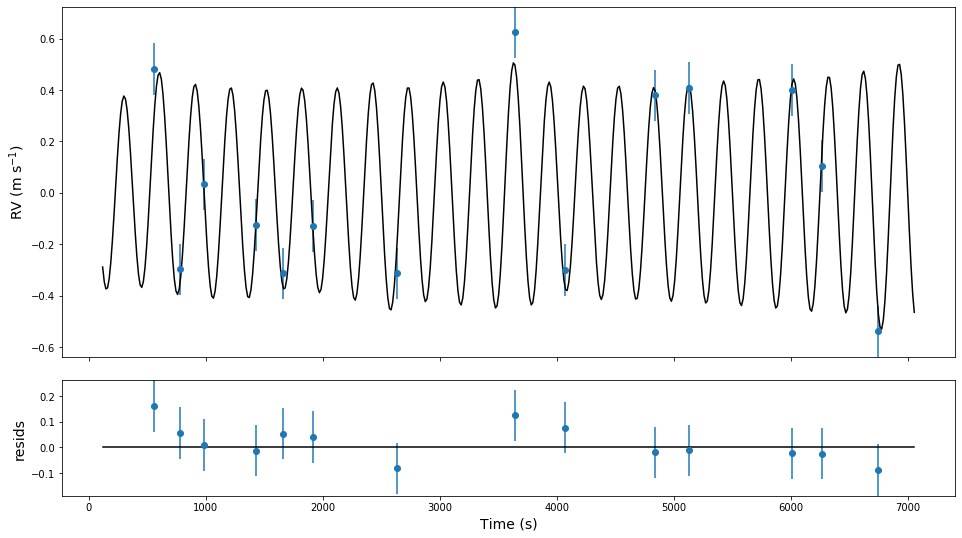

In [25]:
# same m/s/inch
ylim_data = [np.min(y-y_err), np.max(y+y_err)] # 20% above/below max/min errorbar
ylim_resids = [np.min(y_resid-y_err), np.max(y_resid+y_err)]
height_ratios = [(ylim_data[1] - ylim_data[0]) / (ylim_resids[1] - ylim_resids[0]), 1]


fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(16,9), sharex=True, 
                              gridspec_kw={'height_ratios':height_ratios, 'hspace':0.1})
ax1.plot(x_model, y_model, label='model', c='k')
ax1.errorbar(x, y, y_err, label='data', ls='', marker='o')
ax1.set_ylim(ylim_data)

ax2.plot(x_model, np.zeros_like(x_model), c='k')
ax2.errorbar(x, y_resid, y_err, ls='', marker='o')
ax2.set_ylim(ylim_resids)

ax2.set_xlabel('Time (s)', fontsize=14)
ax1.set_ylabel(r'RV (m s$^{-1}$)', fontsize=14)
ax2.set_ylabel(r'resids', fontsize=14);